# Fast fixed-point Gaussian Naive Bayes 
for implementation in microcontrollers

Jon Nordby <jonnord@nmbu.no>, April 2018


## Summary

A fast simplification to `normpdf(x, mean, std)` can be derived sing the minus log-likelihood for calculating the class probability in Gaussian Naive Bayes. Increasing the model size by 50% allows classification to be done without needing to compute any logarithm or exponentiation. The algorithm can be implemented in fixed-point arithmetics using only multiplication, subtraction and addition.
The speed and simplicity makes it especially suited for use on constrained devices without a floating-point unit,
such as microcontrollers typically used for Internet of Things.

When used in [embayes](https://github.com/jonnor/embayes) Naive Bayes classifier, a 16x speedup was observed on ESP8266 microcontrollers.


## Prior art
This simplification is used for instance in [Fast Gaussian Naïve Bayes for searchlight classification analysis](https://www.sciencedirect.com/science/article/pii/S1053811917307371) (equation 2), but without mention of whether they precompute to avoid all logarithms.

## Background

[Naive Bayes classifier](https://en.wikipedia.org/wiki/Naive_Bayes_classifier) is based on finding which class has the highest (conditional) probability when considering all features.

Mathematically this amounts to multiplying each of the individual probabilities.

$ P_{class} = P_1 * P_2 * ... * P_n  \tag{1} $

In practice multiplying probabilities is vunerable to underflow when performed on a computer with finite precision arithmetics. Instead the calculation is performed by taking the log of each probability. The multiplication then becomes an addition.

$ P_{class} = \log(P_1) + \log(P_2) + ... + \log(P_n) \tag{2} $ 

For *Gaussian* Naive Bayes, individual probability is calculated using the Normal Probability Density Function.

$ normpdf(x,\mu,\sigma^2) = \frac{1}{\sigma\sqrt{2\pi}} e^{ -\frac{1}{2}\left(\frac{x-\mu}{\sigma}\right)^2 } \tag{3} $

Probability for a given feature $x_n$ for a given class $A$

$ P_n = \log(normpdf(x_n, \mu_A, \sigma_A)) \tag{4} $

The logarithm in `(4)` and exponent in `(3)` are both relatively complex calculations compared to the other operations needed.

## Simplification

However it [can be shown][1] that this is equivalent to:

$ P_n(x_n, \mu, \sigma) = -\frac{(x - \mu)^2}{2 \sigma^2} - \log(\sigma) + \frac{1}{2} (-\log(2) - \log(\pi)) \tag{5} $

The last term is a constant ($C$) which can be precomputed. $log(σ)$ depends only on a model coefficient $σ$ and can be computed at training time. By storing that as an additional coefficient $b$ (increasing model size by 50%), we simplify the computation done at prediction time to:

$ P_n(x_n, \mu, \sigma, b) =  -\frac{(x - \mu)^2}{2 \sigma^2} - b + C \tag{6} $ 

Which should be significantly faster than `(4)` and easy to implement using fixed-point arithmetics.


Storing $ a = \frac{1}{2 \sigma^2} $ as a model coefficient instead of $\sigma$ allows to further simplify.

$ P_n(x_n, \mu, a, b) = -({a(x - \mu)^2}) - b + C \tag{7} $

Removal two multiplications and conversion of division to multiplication should make it slightly faster.

[1]: https://www.wolframalpha.com/input/?i=%5Clog(%5Cfrac%7B1%7D%7B%5Csigma%5Csqrt%7B2%5Cpi%7D%7D+e%5E%7B+-%5Cfrac%7B1%7D%7B2%7D%5Cleft(%5Cfrac%7Bx-%5Cmu%7D%7B%5Csigma%7D%5Cright)%5E2)

### Specialization for comparisons

Naive Bayes only care about which probability is the highest. This means that the `C` term which is common to all the probabilities can be dropped. And by searching for the minimum instead of maximum one can flip the signs to remove one subtraction.

$ Q_{min}(x_n, \mu, a, b) = {a(x - \mu)^2} + b \tag{8} $

This however cannot be used as a general replacement for `log(normpdf(x, mean, std))` 

## Python example

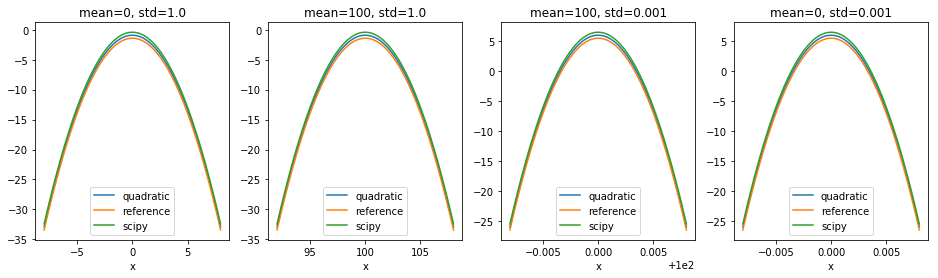

In [53]:
%matplotlib inline

import pandas
import numpy
import scipy.stats
import matplotlib.pyplot as plt

# Reference implementation
def normpdf_scipy(x, mean, std):
    norm = scipy.stats.norm.pdf(x, mean, std)
    return numpy.log(norm)

def normpdf_ref(x, mean, std):
    exponent = -( (x - mean)**2 / (2 * std**2) )
    norm = numpy.exp(exponent) / (numpy.sqrt(2*numpy.pi) * std)
    return numpy.log(norm)

# Our simplified function
C = 1/2*(-numpy.log(2)-numpy.log(numpy.pi))
def normpdf_quadratic(x, mean, std, logstd):
    return -( (x-mean)**2/(2* std**2) ) - logstd + C

sigma = 8
means, stds = ((0, 100, 100, 0), (1.0, 1.0, 0.001, 0.001))
figure, subplots = plt.subplots(1, len(means), figsize=(16,4)) 
for mean, std, ax in zip(means, stds, subplots):
    points = numpy.linspace(mean-(sigma*std), mean+(sigma*std), 100)
    
    df = pandas.DataFrame({
        'x': points,
        'scipy':     normpdf_ref(points, mean, std) + 0.5, # translate so can be seen
        'reference': normpdf_scipy(points, mean, std) - 0.5, # translate so can be seen
        'quadratic': normpdf_quadratic(points, mean, std, numpy.log(std))
    })
    df.plot(ax=ax, x='x', title='mean={}, std={}'.format(mean, std))

Simplified function is identical to references.

NOTE: height difference added manually, so that the different curves can actually be seen.

## Performance

**! Preliminary results **

On ESP8266, a 32-bit microcontroller without an FPU.
Dataset with 30 features and 2 classes.

Average classification time per instance:

* Original `log(normpdf())` with 32bit floating point: 6.85 ms
* Simplified quadratic function `(6)` in 32bit fixed-point: 0.41 ms

For a speedup of 16x

### TODO

* Implement and test `(7)` or `(8)`
* Show code used inline
* Show classification results
* Do classification tests on multiple datasets

Performance comparison on

* ESP8266, AVR8, ARM Cortex-M0, x86_64(Linux) in C
* For original 6,8 in floating-point and 6/8 with fixed-point.
* Execution time, code size, model size



## Further work

Find out if there the optimization can be used in other Gaussian-based machine learning methods.

Investigate a version which does not require additional model coefficient.
